In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from datetime import datetime, timedelta
from collections import OrderedDict
import calendar
import seaborn as sns
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.holtwinters import ExponentialSmoothing as HW_Model

# Пробуем прогнозировать индекс потребительских цен с помощью модели Хольта Уинтерса
Исходные данные - эксель файл, которые содержить данные индекса потребительских цен (ИПЦ) на каждый месяц с 2000 по 2022 год (получается 12 * 23 = 276 значений). Нужно обучить модель Хольта Уинтерса (МХоУ) для прогнозирования ИПЦ на 1 год (12 периодов). Предполагается, что сезон равен 1 году, в нем 12 периодов. 
МХоУ выглядит следующим образом:
$$ x_{N+\tau} = (a_N\tau + b_N)F(\tau-L)$$
где:

$N$ - общее количество значений в заденной выборке (до 276);

$L$ - количество периодов в сезоне (12);

$x_{N+\tau}$ - прогнозный период;

$a_N, b_N$ - коэффициенты парной линейной регрессии, оцененные в последнем периоде последнего сезона из заданной выборки;

$F(\tau-L)$  - коэффициент сезонности - мультипликативная корректировка линии регрессии в зависиомсти от периода сезонности.

Параметры модели: $a_N$, $b_N$, $F(...)$ подбираются с применением подхода тройного экспонециального сглаживания.

Начальные значения $a_0$, $b_0$ определяются как коэффициенты парной регрессии, формируемой для всей обучающей выборки

Начальные коэффициенты сезонности $F(-L+1), F(-L+2),..., F(0)$ получаются частными в соответсвующих периодах и взятием от них среднего значения. Далее идет итерационный процесс с применением подхода тройного экспоненциального сглаживания: для трендовой, аддитивной и сезонной компонент с использованием параметров сглаживания (для каждой из них).

## Загружаем данные из экселевского файла

In [2]:
data = pd.read_excel('cpi2000-2022.xlsx', index_col='Unnamed: 0')
#пока не поставил второй аргумент (index_col='Unnamed: 0'), данные нормально не считывались

In [3]:
data.columns

Int64Index([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
            2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021,
            2022],
           dtype='int64')

In [4]:
data.shape

(12, 23)

In [5]:
data

,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
январь,102.33,102.76,103.09,102.40,101.75,102.62,102.43,101.68,102.31,102.37,...,100.97,100.59,103.85,100.96,100.62,100.31,101.01,100.40,100.67,100.99
февраль,101.04,102.28,101.16,101.63,100.99,101.23,101.66,101.11,101.20,101.65,...,100.56,100.70,102.22,100.63,100.22,100.21,100.44,100.33,100.78,101.17
март,100.64,101.86,101.08,101.05,100.75,101.34,100.82,100.59,101.20,101.31,...,100.34,101.02,101.21,100.46,100.13,100.29,100.32,100.55,100.66,107.61
апрель,100.89,101.79,101.16,101.02,100.99,101.12,100.35,100.57,101.42,100.69,...,100.51,100.90,100.46,100.44,100.33,100.38,100.29,100.83,100.58,101.56
май,101.75,101.78,101.69,100.80,100.74,100.80,100.48,100.63,101.35,100.57,...,100.66,100.90,100.35,100.41,100.37,100.38,100.34,100.27,100.74,100.12
июнь,102.55,101.62,100.53,100.80,100.78,100.64,100.28,100.95,100.97,100.60,...,100.42,100.62,100.19,100.36,100.61,100.49,100.04,100.22,100.69,99.65
июль,101.79,100.45,100.72,100.71,100.92,100.46,100.67,100.87,100.51,100.63,...,100.82,100.49,100.80,100.54,100.07,100.27,100.20,100.35,100.31,99.61
август,100.98,100.01,100.09,99.59,100.42,99.86,100.19,100.09,100.36,100.00,...,100.14,100.24,100.35,100.01,99.46,100.01,99.76,99.96,100.17,99.48
сентябрь,101.32,100.60,100.40,100.34,100.43,100.25,100.09,100.79,100.80,99.97,...,100.21,100.65,100.57,100.17,99.85,100.16,99.84,99.93,100.60,100.05
октябрь,102.11,101.09,101.07,101.00,101.14,100.55,100.28,101.64,100.91,100.00,...,100.57,100.82,100.74,100.43,100.20,100.35,100.13,100.43,101.11,100.18


In [6]:
Months = data.index
Months

Index(['январь', 'февраль', 'март', 'апрель', 'май', 'июнь', 'июль', 'август',
       'сентябрь', 'октябрь', 'ноябрь', 'декабрь'],
      dtype='object')

## Разбираемся в данных

In [7]:
data.describe()

,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
count,12.000000,12.000000,12.000000,12.00000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,...,12.00000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000
mean,101.546667,101.433333,101.178333,100.95000,100.930000,100.869167,100.722500,100.940000,101.045833,100.707500,...,100.52250,100.902500,101.021667,100.437500,100.208333,100.349167,100.250833,100.400833,100.674167,100.964167
std,0.597728,0.785057,0.779053,0.66941,0.356931,0.689380,0.680416,0.456489,0.512879,0.729871,...,0.23371,0.603341,1.037916,0.230341,0.320591,0.206021,0.317732,0.295495,0.254074,2.192526
min,100.640000,100.010000,100.090000,99.59000,100.420000,99.860000,100.090000,100.090000,100.360000,99.970000,...,100.14000,100.240000,100.190000,100.010000,99.460000,100.010000,99.760000,99.930000,100.170000,99.480000
25%,101.025000,100.967500,100.672500,100.77750,100.747500,100.527500,100.280000,100.620000,100.772500,100.217500,...,100.40000,100.612500,100.432500,100.390000,100.115000,100.255000,100.107500,100.257500,100.595000,99.950000
50%,101.580000,101.610000,101.120000,100.98000,100.955000,100.770000,100.555000,100.910000,100.940000,100.585000,...,100.53500,100.760000,100.745000,100.435000,100.220000,100.330000,100.285000,100.375000,100.680000,100.275000
75%,101.870000,101.807500,101.557500,101.06250,101.117500,101.147500,100.797500,101.155000,101.237500,100.845000,...,100.59250,100.930000,100.902500,100.480000,100.382500,100.407500,100.345000,100.590000,100.790000,101.035000
max,102.550000,102.760000,103.090000,102.40000,101.750000,102.620000,102.430000,101.680000,102.310000,102.370000,...,100.97000,102.620000,103.850000,100.960000,100.620000,100.840000,101.010000,100.830000,101.110000,107.610000


Данные представленны в виде матрицы: по годам и месяцам, поэтом так быстро с помощью describe() ничего из них не получишь. Нужно сначала из них получить временной ряд.

In [8]:
np_array=data.to_numpy()
np_row = np.reshape(np_array, 276, order='F')
# Вот он и получился - одномерный массив np_row
np_row

array([102.33, 101.04, 100.64, 100.89, 101.75, 102.55, 101.79, 100.98,
       101.32, 102.11, 101.52, 101.64, 102.76, 102.28, 101.86, 101.79,
       101.78, 101.62, 100.45, 100.01, 100.6 , 101.09, 101.36, 101.6 ,
       103.09, 101.16, 101.08, 101.16, 101.69, 100.53, 100.72, 100.09,
       100.4 , 101.07, 101.61, 101.54, 102.4 , 101.63, 101.05, 101.02,
       100.8 , 100.8 , 100.71,  99.59, 100.34, 101.  , 100.96, 101.1 ,
       101.75, 100.99, 100.75, 100.99, 100.74, 100.78, 100.92, 100.42,
       100.43, 101.14, 101.11, 101.14, 102.62, 101.23, 101.34, 101.12,
       100.8 , 100.64, 100.46,  99.86, 100.25, 100.55, 100.74, 100.82,
       102.43, 101.66, 100.82, 100.35, 100.48, 100.28, 100.67, 100.19,
       100.09, 100.28, 100.63, 100.79, 101.68, 101.11, 100.59, 100.57,
       100.63, 100.95, 100.87, 100.09, 100.79, 101.64, 101.23, 101.13,
       102.31, 101.2 , 101.2 , 101.42, 101.35, 100.97, 100.51, 100.36,
       100.8 , 100.91, 100.83, 100.69, 102.37, 101.65, 101.31, 100.69,
      

In [9]:
# Этот полезный код, который представлен Кристиной (преподавателем) делает классную вещь - выстраивает исходную таблицу data 
# в однострочный датафрейм, в котором индексная строка определяется объединением месяцев и годов. Функция stack отлично 
# выстраивает из таблицы строку 

# new_data = data.T.stack().to_frame()
# new_columns = new_data.index.to_flat_index()
# new_data = new_data.T
# new_data.columns = [f'{col_name[1]}, {col_name[0]}' for col_name in new_columns]
# new_data = new_data.T

# Но, поскольку уже был однострочный список, а для визуализации нужны колоночные данные, то решили создать массив дат:
# каждый элемент такого массива соответствовал дате нужного месяца, например, 1.01.2000, 1.02.2000 и т.д.
# Далее из массива данных и полученноного списка формироваолся нужный фрейм для визуализации в форме графика - см. ниже.

In [10]:
dates_list = []
months_list = []
years_list = []
curr_date = datetime(day=1, month=1, year=2000)
for i in range(23*12): 
    days_in_month = calendar.monthrange(curr_date.year, curr_date.month)[1]
    dates_list.append(curr_date)
    months_list.append(curr_date.month)
    years_list.append(curr_date.year)    
    curr_date = curr_date  + timedelta(days=days_in_month)



In [11]:
# new_data.insert(0,"Date",dates)

In [12]:
new_data_a = pd.DataFrame()
new_data_a["Dates"] = dates_list
new_data_a["Values"] = np_row
new_data_a["Years"] = years_list
new_data_a["Months"] = months_list
new_data_a
# получилось то, что нужно для визуализации

,Dates,Values,Years,Months
0,2000-01-01,102.33,2000,1
1,2000-02-01,101.04,2000,2
2,2000-03-01,100.64,2000,3
3,2000-04-01,100.89,2000,4
4,2000-05-01,101.75,2000,5
...,...,...,...,...
271,2022-08-01,99.48,2022,8
272,2022-09-01,100.05,2022,9
273,2022-10-01,100.18,2022,10
274,2022-11-01,100.37,2022,11


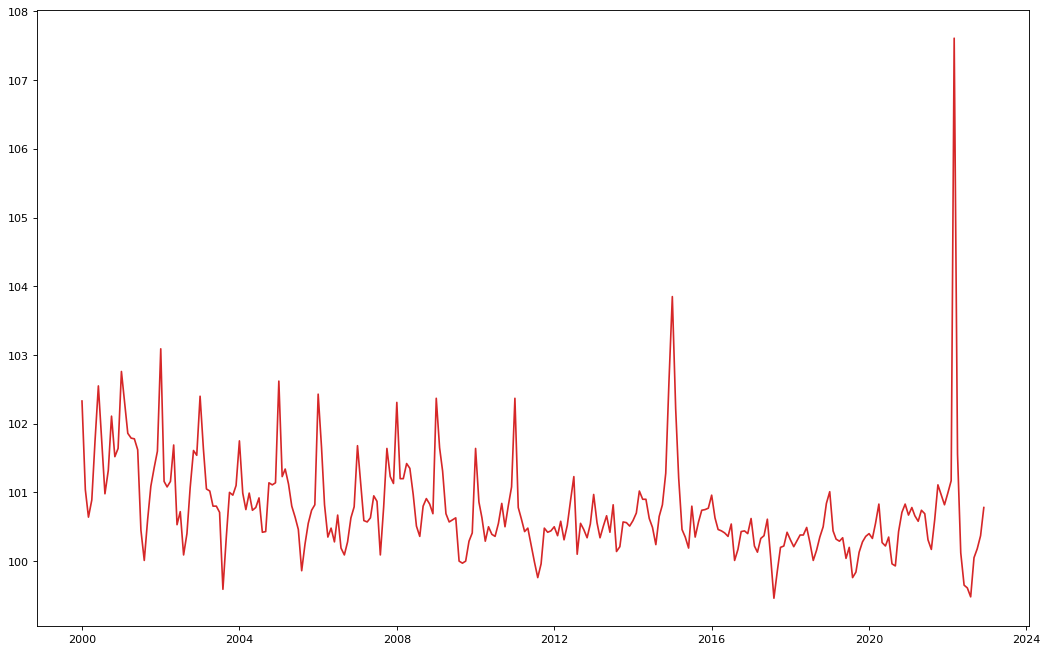

In [13]:
plt.figure(figsize=(16,10), dpi= 80)
plt.plot(new_data_a["Dates"], new_data_a["Values"], color='tab:red')
plt.show()

### Смотрим корреляцию между рядами данных по годом (12 значений для каждого из с 2000 по 2022 годов)

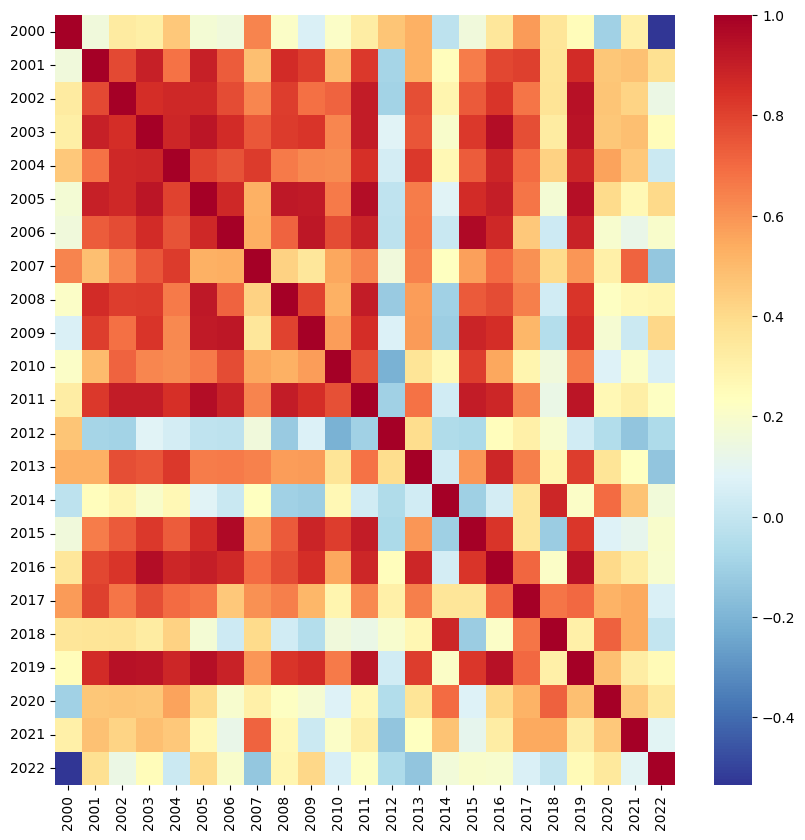

In [14]:
plt.figure(figsize=(10,10))
sns.heatmap(data.corr(), cmap="RdYlBu_r");

Хорошо заметно, что, ряды между собой хорошо коррелированы в начальных года, а также в 2019 году. Выбивается сильно 2012 и 2014 года. 2014 - причины понятны, а 2012 - странно. Встречается практически нулевая корреляция между годами. В частности между 2021 и 2022 годами, что можно объяснить известными событиями. Так сама матрица очень интересна!
В целом можно говорить, что ряды помесячных значений в основном имеют хорошую корреляцию.

### Нужно смотреть сезонность, а для этого снача вычислим коэффициенты линейной регрессии

In [15]:
lr = LinearRegression()
x_train = new_data_a[["Dates"]]
# хоть и парная регрессия, но нужно первым параметром lr.fit подобавать именно таблицу!!! Поэтому двойные квадратные скобки
for i in range (23*12):
    x_train.at[i, 'Dates'] = i
y_train = new_data_a["Values"]
#new_data_a.at[267, 'Value'] = 102.0 #убираем выброс март 2022
lr.fit(x_train,y_train)
x_train

,Dates
0,0
1,1
2,2
3,3
4,4
...,...
271,271
272,272
273,273
274,274


In [16]:
print(lr.coef_[0])
print(lr.intercept_)

-0.0031275809420527713
101.2034481766337


In [17]:
lr_values = []
for i in range(23*12):
    lr_value = x_train['Dates'].loc[x_train.index[i]] * lr.coef_[0] + lr.intercept_
    lr_values.append(lr_value)
lr_values

[101.2034481766337,
 101.20032059569165,
 101.1971930147496,
 101.19406543380754,
 101.19093785286549,
 101.18781027192344,
 101.18468269098139,
 101.18155511003933,
 101.17842752909728,
 101.17529994815523,
 101.17217236721318,
 101.16904478627112,
 101.16591720532907,
 101.16278962438702,
 101.15966204344497,
 101.1565344625029,
 101.15340688156085,
 101.1502793006188,
 101.14715171967676,
 101.1440241387347,
 101.14089655779264,
 101.1377689768506,
 101.13464139590855,
 101.13151381496648,
 101.12838623402443,
 101.12525865308238,
 101.12213107214033,
 101.11900349119827,
 101.11587591025622,
 101.11274832931417,
 101.10962074837212,
 101.10649316743006,
 101.10336558648801,
 101.10023800554596,
 101.09711042460391,
 101.09398284366185,
 101.0908552627198,
 101.08772768177775,
 101.0846001008357,
 101.08147251989364,
 101.07834493895159,
 101.07521735800954,
 101.07208977706749,
 101.06896219612543,
 101.06583461518338,
 101.06270703424133,
 101.05957945329928,
 101.05645187235721,


In [18]:
new_data_a["LR_Value"] = lr_values

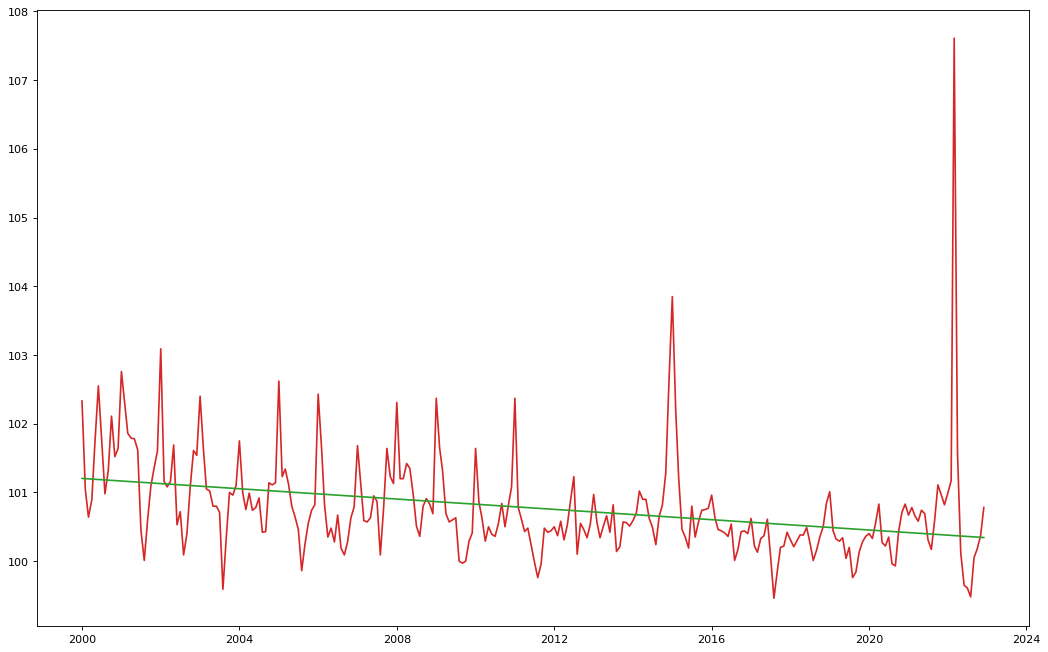

In [19]:
plt.figure(figsize=(16,10), dpi= 80)
plt.plot(new_data_a["Dates"], new_data_a["Values"], color='tab:red')
plt.plot(new_data_a["Dates"], new_data_a["LR_Value"], color='tab:green')
plt.show()
# Вывели линию регрессии :-)

### По ходу посмотрим статистическую визуализацию: ящик с --ушами--  (ой) с усами, ядерная плотность и гистограмма для всего ряда

<AxesSubplot: >

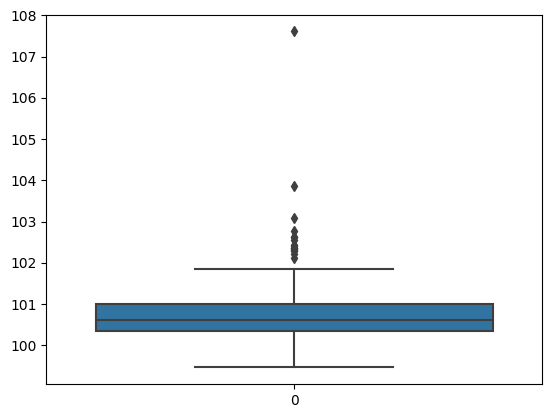

In [20]:
sns.boxplot(data = new_data_a["Values"])

Значения совредоточены между 99,5 и 101, но есть выбросы выше 102...

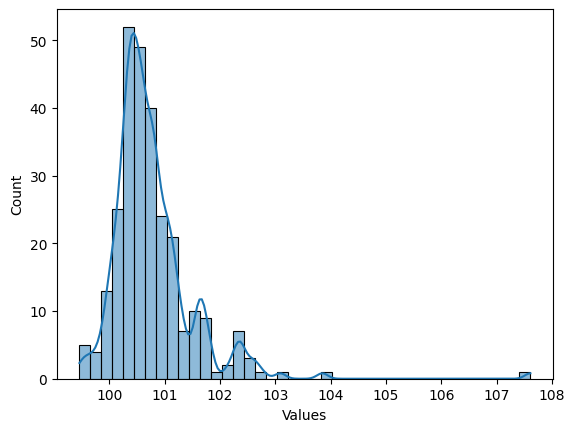

In [21]:
sns.histplot(data=new_data_a["Values"], kde=True, kde_kws={'bw_adjust': 0.4});
# выведем гистрограмму с оценкой плотности распределения ядра со сглаживающей полосой пропускания 0,75 

В целом ядро очень похоже на плотность нормального распределения, но выбросы вносят в него изменения с правой стороны.Работаем с выбросами

Строим две диаграммы: 12 графиков до 2011 года включительно и 13 графиков с 2012 по 2022 годы.

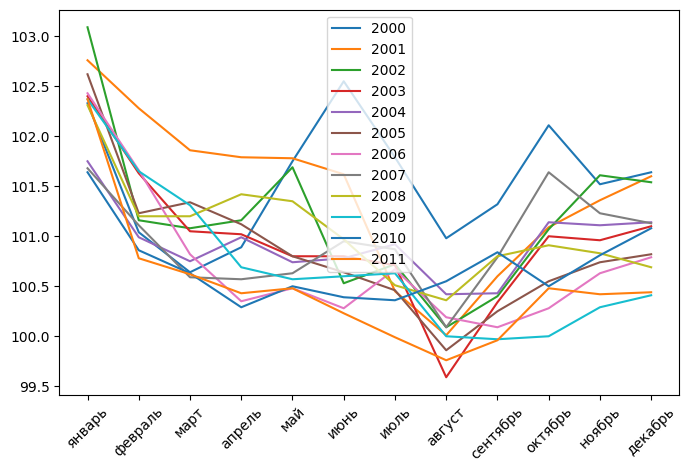

In [22]:
fig, ax = plt.subplots()


for i in range(2000,2012):
    ax.plot(data.index, data[i], label = str(i))
ax.legend()

fig.set_figheight(5)
fig.set_figwidth(8)
plt.xticks(rotation = 45)
plt.show()

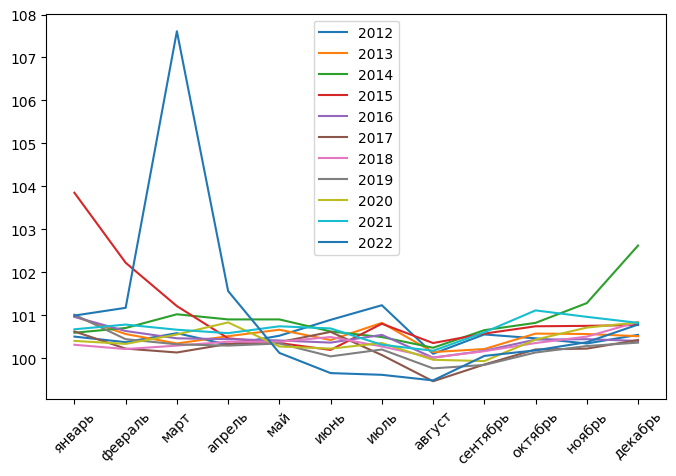

In [23]:
fig, ax = plt.subplots()


for i in range(2012,2023):
    ax.plot(data.index, data[i], label = str(i))
ax.legend()


fig.set_figheight(5)
fig.set_figwidth(8)
plt.xticks(rotation = 45)
plt.show()

### Пройдемся по месячным значениям (23 январьских, 23 февральских и т.д.) и визуализируем для них статистические данные

In [24]:
TData = data.T
# for column in TData:
#    columnSeriesObj = TData[column]    


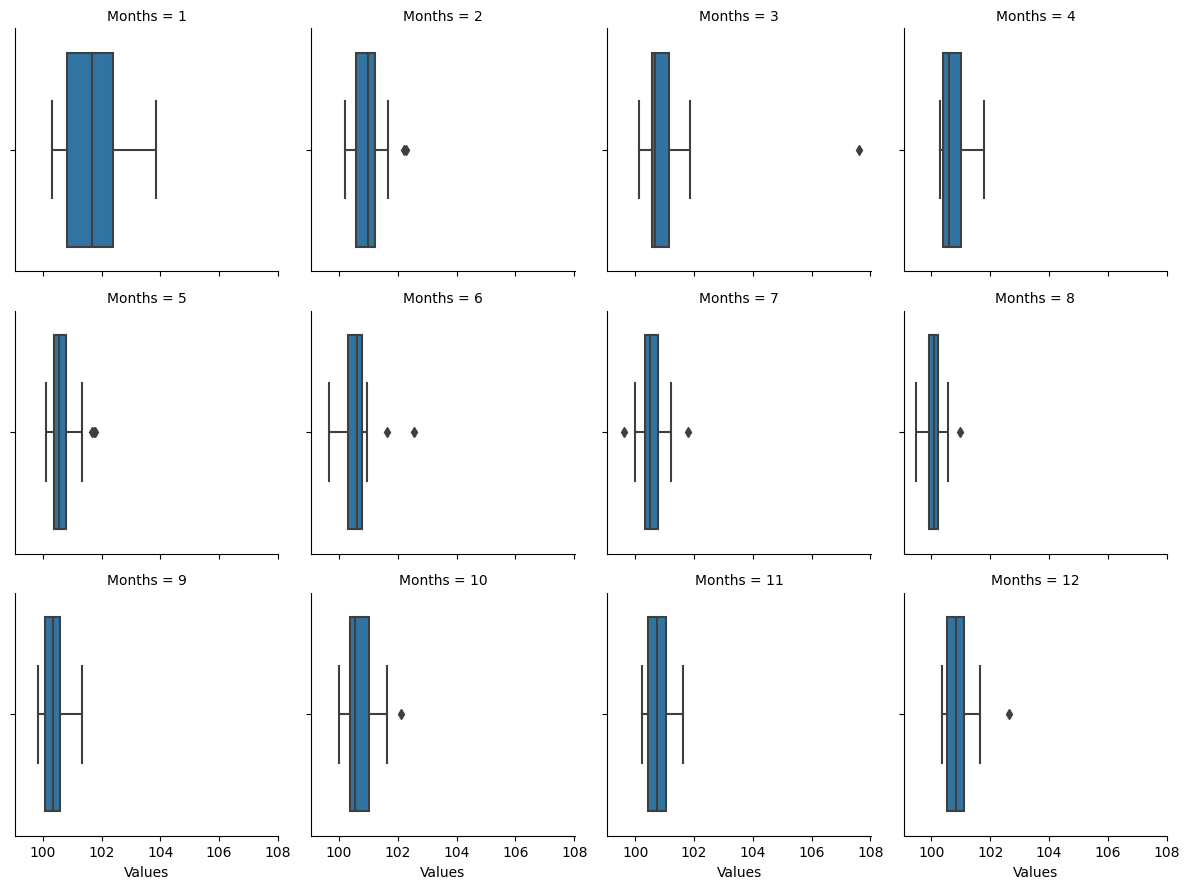

In [25]:
# Визуализируем ящики с усами для каждой колонки (например, янврские даты за все года)
# так можно, но муторно и некрасиво
# for column in TData:
#    columnSeriesObj = TData[column]
#    sns.boxplot(data = columnSeriesObj.values)

# Пробуем так:
g = sns.FacetGrid (data=new_data_a, col='Months', col_wrap=4, legend_out=False)
g.map (sns.boxplot, 'Values')

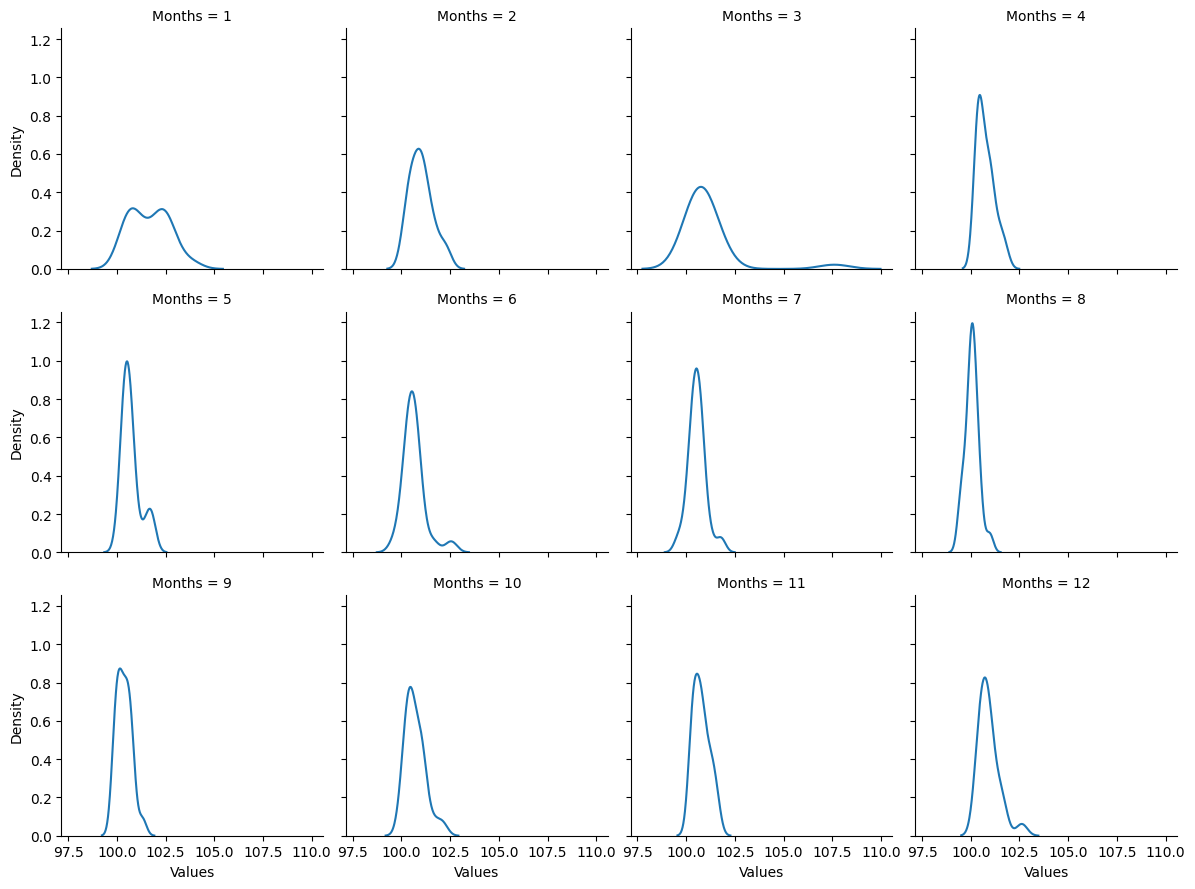

In [26]:
g = sns.FacetGrid (data=new_data_a, col='Months', col_wrap=4, legend_out=False)
g.map (sns.kdeplot, 'Values')

Сильный разброс в январе, на март повлиял выброс 2022 года (понятно, почему), в мае, июне, декабре есть как бы "вторая гармоника", сентябрь и октябрь смотрится более менее. Существенные выбросы марта 2022 года, декабря 2014, января 2015 года необходимо корректировать. Также нужно обратить внимание на "отскок" с мая по июль 2022 года ("замедление" роста цен летом 2022 года)

In [27]:
# sns.pairplot(data); 
# не надо этого делать - колонок очень много в исходной таблице - система строит эту "мегаматрицу" в течение 5-7 минут...

### А здесь корректируем данные: фактическое значение делим но вычисленное по модели регрессии - выделяется доля разницы между линейно-трендовым значением и фактическим

In [28]:
new_data_a['Periods'] = new_data_a['Values']/new_data_a['LR_Value']

In [29]:
new_data_a

,Dates,Values,Years,Months,LR_Value,Periods
0,2000-01-01,102.33,2000,1,101.203448,1.011132
1,2000-02-01,101.04,2000,2,101.200321,0.998416
2,2000-03-01,100.64,2000,3,101.197193,0.994494
3,2000-04-01,100.89,2000,4,101.194065,0.996995
4,2000-05-01,101.75,2000,5,101.190938,1.005525
...,...,...,...,...,...,...
271,2022-08-01,99.48,2022,8,100.355874,0.991272
272,2022-09-01,100.05,2022,9,100.352746,0.996983
273,2022-10-01,100.18,2022,10,100.349619,0.998310
274,2022-11-01,100.37,2022,11,100.346491,1.000234


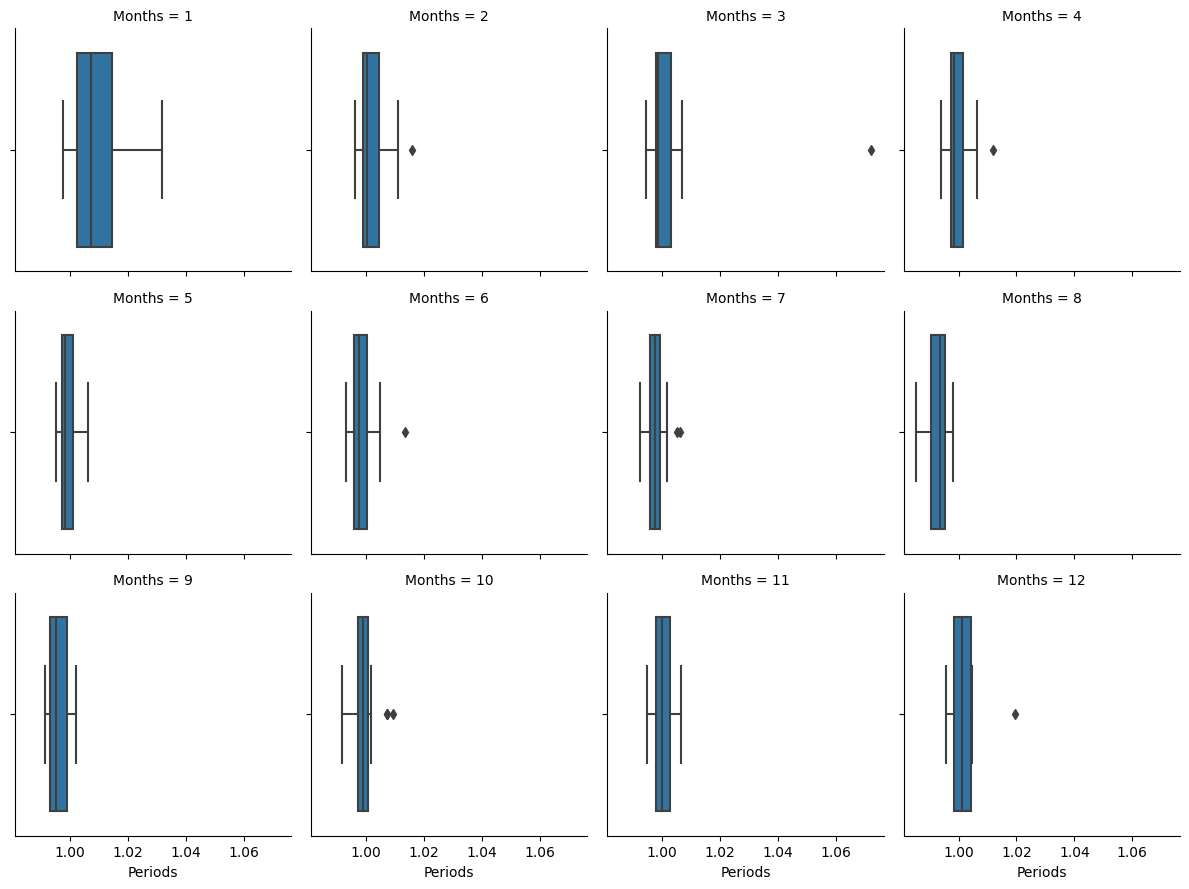

In [30]:
g = sns.FacetGrid (data=new_data_a, col='Months', col_wrap=4, legend_out=False)
g.map (sns.boxplot, 'Periods')

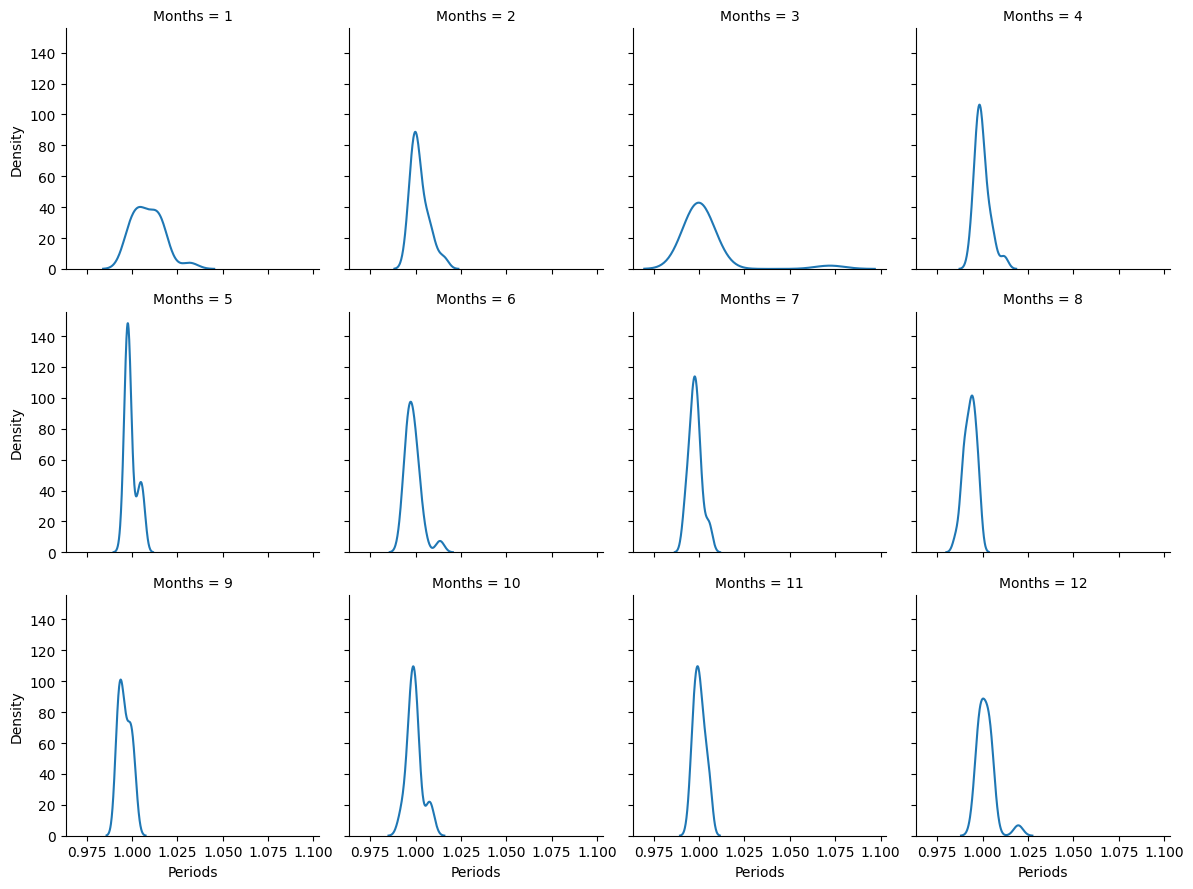

In [31]:
g = sns.FacetGrid (data=new_data_a, col='Months', col_wrap=4, legend_out=False)
g.map (sns.kdeplot, 'Periods')

## Строим "Бейзлайн"

Базовое решение или "Бейзлайн" будет строиться на основе стандартной модели Хольта-Уинтерса с параметрами сглаживания: 0,1; 0,2; 0,3.

In [32]:
df_train = new_data_a["Values"].iloc[:-12]
# Для тестирования оставляем 2022 год
df_test = new_data_a["Values"].iloc[-12:]

In [33]:
# Создаем и обучаем модель Хольта-Уинтерса: тренд добавляется, а сезонность - умножается
model = HW_Model(df_train, seasonal_periods = 12, trend = "add", seasonal = "mul")
fit_model = model.fit(smoothing_level = 0.1, smoothing_trend = 0.2, smoothing_seasonal = 0.3)

In [34]:
# Напечатаем данные обученной модели
print(fit_model.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                   Values   No. Observations:                  264
Model:             ExponentialSmoothing   SSE                             59.206
Optimized:                         True   AIC                           -362.660
Trend:                         Additive   BIC                           -305.445
Seasonal:                Multiplicative   AICC                          -359.868
Seasonal Periods:                    12   Date:                 Tue, 14 Feb 2023
Box-Cox:                          False   Time:                         11:58:31
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.1000000                alpha                False
smoothing_trend          

In [35]:
CPI_forecast = fit_model.forecast(steps=12)

In [36]:
CPI_forecast

264    101.208166
265    101.054402
266    101.037234
267    101.080217
268    101.038014
269    100.997660
270    100.927071
271    100.616878
272    100.856628
273    101.259309
274    101.331886
275    101.515502
dtype: float64

In [37]:
df_test

264    100.99
265    101.17
266    107.61
267    101.56
268    100.12
269     99.65
270     99.61
271     99.48
272    100.05
273    100.18
274    100.37
275    100.78
Name: Values, dtype: float64

In [38]:
# Готовим данные для показа реальных данных 2022 года,
# спрогнозированных данных на 2022 год.
real_local = []
for_local = []
dates_local = []
curr_date = datetime(day=1, month=1, year=2022)
for i in range(12): 
    days_in_month = calendar.monthrange(curr_date.year, curr_date.month)[1]
    dates_local.append(curr_date)
    curr_date = curr_date  + timedelta(days=days_in_month)
    real_local.append(new_data_a["Values"].iloc[264+i])
    for_local.append(CPI_forecast.iloc[i])
DF_show = pd.DataFrame()
DF_show["Dates"] = dates_local
DF_show["Real"] = real_local
DF_show["Forecast"] = for_local

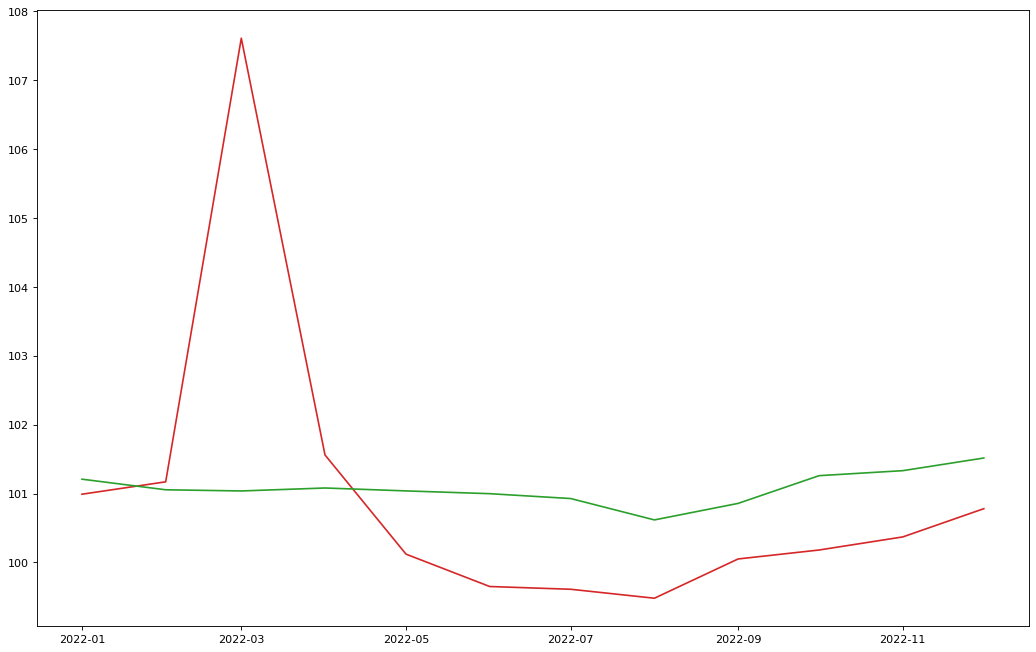

In [39]:
# сравнение реальных значение с прогнозыми (2022 год)
plt.figure(figsize=(16,10), dpi= 80)
plt.plot(dates_local, real_local, color='tab:red')
plt.plot(dates_local, for_local, color='tab:green')
plt.show()

In [40]:
APE = []
for i in range(12):
    per_err = abs((real_local[i] - for_local[i])/real_local[i])
    APE.append(per_err)
MAPE = sum(APE)/len(APE)
print('Средняя относительная ошибка: ' + str(MAPE))

Средняя относительная ошибка: 0.012680626467093897


Бейзлайн плохонький даже при такой малой ошибке. Большие неприятности дают выбросы, да и параметры сглаживания подобраны "на обум"...
Необходимо чистить данные и подбирать гиперпараметры, в том числе методом кросс-валидации.